In [33]:
import os
import sys

sys.path.append(os.getcwd())

import utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, v_measure_score

In [34]:
#Data frames from previous notebook

final_df = pd.read_pickle("../data/processed_data.pkl")
train_split = pd.read_pickle("../data/train_split.pkl")
test_split = pd.read_pickle("../data/test_split.pkl")
results = pd.read_pickle("../data/results.pkl").to_dict()
final_df_model = final_df.drop(columns = ["Median GRPS Score"])
df_train_features = train_split
df_test_features = test_split
df_train_target = df_train_features["Runner_Class"]
df_test_target = df_test_features["Runner_Class"]
df_train_features_numeric = df_train_features.select_dtypes(include=[int, float])
df_test_features_numeric = df_test_features.select_dtypes(include=[int, float])


### Sensitivity Analysis: Removing Target Leakage (Calculated Pace)

#### Purpose -
- In this section, we intentionally omit Calculated Pace from the feature set in order to compare model performance without this variable, which appears to have a substantial impact on predictive accuracy.
- We will evaluate the non-linear models Random Forest and Gradient Boosting, as the relationship between heart rate, distance, and runner tier is complex and likely non-linear. For example, a low heart rate at a short distance may indicate an intermediate runner, whereas a similarly low heart rate at a long distance may indicate an advanced runner. I expect that logistic regression may struggle to capture these interactions unless they are explicitly engineered.

In [35]:
df_train_features_numeric_no_pace = df_train_features_numeric.drop(columns = "Median Calculated Pace")
df_test_features_numeric_no_pace = df_test_features_numeric.drop(columns = "Median Calculated Pace")
print(df_train_features_numeric_no_pace.head(6))

     Median Avg HR  Median Distance  Median Time
139        129.700         17.01500    97.916667
25         150.125          9.89600    54.133333
82         158.200         11.03800    65.966667
144        131.900          1.32600     7.066667
66         172.200          5.44385    34.300000
248        120.700          2.77790    15.900000


In [36]:
# Random forest Pipeline
features = final_df_model.drop(columns="Median Calculated Pace").select_dtypes(include=[int, float])
feature_cols = features.columns.tolist()
rf_pipe_no_pace = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv_no_pace = cross_val_predict(rf_pipe_no_pace, df_train_features_numeric_no_pace, df_train_target, cv=cv)
print("CV classification report - Random Forest:")
print(classification_report(df_train_target, y_pred_cv_no_pace, digits=3))

rf_pipe_no_pace.fit(df_train_features_numeric_no_pace, df_train_target)
y_pred_test_no_pace = rf_pipe_no_pace.predict(df_test_features_numeric_no_pace)
print("Test results classification report - Random Forest:")
print(classification_report(df_test_target, y_pred_test_no_pace, digits=3))

train_accuracy = accuracy_score(df_train_target, y_pred_cv_no_pace)
test_accuracy = accuracy_score(df_test_target, y_pred_test_no_pace)

results["Random Forest Without Pace"] = utils.eval_model(rf_pipe_no_pace, df_train_features_numeric_no_pace, df_test_features_numeric_no_pace,df_train_target, df_test_target, "Random Forest Without Pace")


CV classification report - Random Forest:
              precision    recall  f1-score   support

    Advanced      0.656     0.438     0.525        48
    Beginner      0.697     0.657     0.676        70
Intermediate      0.638     0.755     0.692       110

    accuracy                          0.658       228
   macro avg      0.664     0.616     0.631       228
weighted avg      0.660     0.658     0.652       228

Test results classification report - Random Forest:
              precision    recall  f1-score   support

    Advanced      0.556     0.500     0.526        10
    Beginner      0.615     0.533     0.571        15
Intermediate      0.694     0.758     0.725        33

    accuracy                          0.655        58
   macro avg      0.622     0.597     0.607        58
weighted avg      0.650     0.655     0.651        58



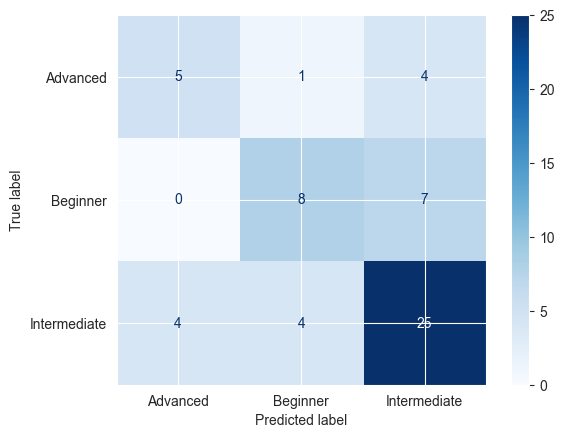

In [37]:
cm = confusion_matrix(df_test_target, y_pred_test_no_pace, labels=rf_pipe_no_pace.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipe_no_pace.classes_)
disp.plot(cmap="Blues")
plt.show()

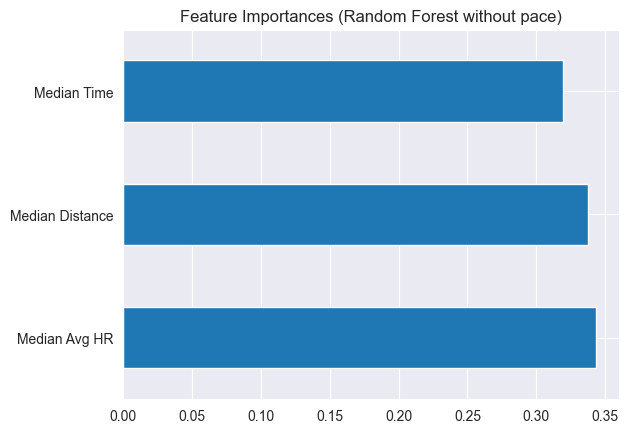

In [38]:
importances = rf_pipe_no_pace.named_steps["rf"].feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
feat_imp.plot(kind="barh")
plt.title("Feature Importances (Random Forest without pace)")
plt.show()

In [39]:
#Gradient boosting
gb_pipe_no_pace = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    ))
])

y_pred_cv_no_pace = cross_val_predict(gb_pipe_no_pace, df_train_features_numeric_no_pace, df_train_target, cv=cv)
print("CV results - Classification report - Gradient Boosting Without Pace:")
print(classification_report(df_train_target, y_pred_cv_no_pace, digits=3))

gb_pipe_no_pace.fit(df_train_features_numeric_no_pace, df_train_target)
y_pred_test_no_pace = gb_pipe_no_pace.predict(df_test_features_numeric_no_pace)
print("Test results - Classification report - Gradient Boosting Without Pace:")
print(classification_report(df_test_target, y_pred_test_no_pace, digits=3))

train_accuracy = accuracy_score(df_train_target, y_pred_cv_no_pace)
test_accuracy = accuracy_score(df_test_target, y_pred_test_no_pace)

results["Gradient Boosting Without Pace"] = utils.eval_model(gb_pipe_no_pace, df_train_features_numeric_no_pace, df_test_features_numeric_no_pace, df_train_target, df_test_target, "Gradient Boosting Without Pace")

CV results - Classification report - Gradient Boosting Without Pace:
              precision    recall  f1-score   support

    Advanced      0.571     0.500     0.533        48
    Beginner      0.754     0.700     0.726        70
Intermediate      0.669     0.736     0.701       110

    accuracy                          0.675       228
   macro avg      0.665     0.645     0.654       228
weighted avg      0.675     0.675     0.673       228

Test results - Classification report - Gradient Boosting Without Pace:
              precision    recall  f1-score   support

    Advanced      0.700     0.700     0.700        10
    Beginner      0.733     0.733     0.733        15
Intermediate      0.818     0.818     0.818        33

    accuracy                          0.776        58
   macro avg      0.751     0.751     0.751        58
weighted avg      0.776     0.776     0.776        58



Confusion matrix - Gradient Boosting Without Pace


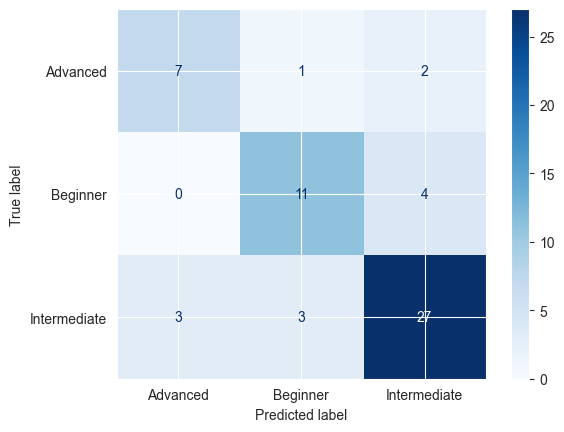

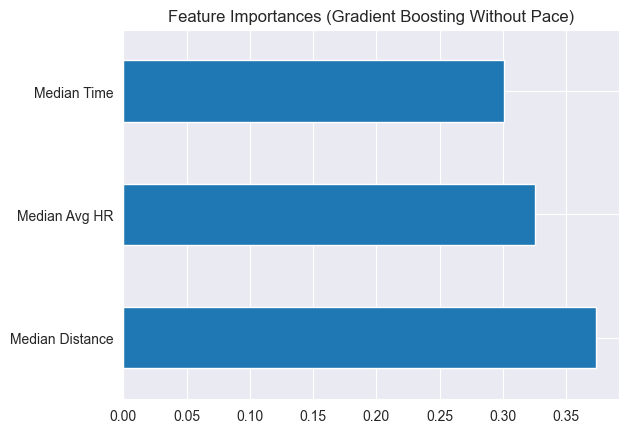

In [40]:
print("Confusion matrix - Gradient Boosting Without Pace")
cm = confusion_matrix(df_test_target, y_pred_test_no_pace, labels=gb_pipe_no_pace.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_pipe_no_pace.classes_)
disp.plot(cmap="Blues")
plt.show()

importances = gb_pipe_no_pace.named_steps["gb"].feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
feat_imp.plot(kind="barh")
plt.title("Feature Importances (Gradient Boosting Without Pace)")
plt.show()

In [41]:
results_df = pd.DataFrame(results).sort_values("Accuracy", ascending = False)

styled_results = (
    results_df.style
    .format({"Accuracy": "{:.3f}", "Macro F1": "{:.3f}", "Macro Precision":"{:.3f}", "Macro Recall":"{:.3f}"})
    .highlight_max("Accuracy", color="#ABEBC6")
    .highlight_max("Macro F1", color="#ABEBC6")
    .highlight_max("Macro Precision", color="#ABEBC6")
    .highlight_min("Accuracy", color="#F5B7B1")
    .highlight_min("Macro F1", color = "#F5B7B1")
    .highlight_min("Macro Precision", color = "#F5B7B1")
    .highlight_max("Macro Recall", color = "#ABEBC6")
    .highlight_min("Macro Recall", color = "#F5B7B1")
)
display(styled_results)

,Model,Accuracy,Macro F1,Macro Precision,Macro Recall,Random Forest Without Pace,Gradient Boosting Without Pace
1,Logistic Regression,0.966,0.957,0.957,0.957,nan,nan
2,Random Forest,0.862,0.840,0.844,0.837,nan,nan
3,Gradient Boosting,0.828,0.794,0.794,0.794,nan,nan
0,SKL Decision Tree,0.690,0.626,0.661,0.656,nan,nan
Model,nan,nan,nan,nan,nan,Random Forest Without Pace,Gradient Boosting Without Pace
Accuracy,nan,nan,nan,nan,nan,0.655172,0.775862
Macro F1,nan,nan,nan,nan,nan,0.607461,0.750505
Macro Precision,nan,nan,nan,nan,nan,0.621795,0.750505
Macro Recall,nan,nan,nan,nan,nan,0.596970,0.750505


#### Conclusions – Comparison Between Models With and Without Calculated Pace
 - The Random Forest model achieved an accuracy of 77% when trained with Calculated Pace, but this performance was influenced by data leakage. When the feature was removed, accuracy dropped to 62%.
 - The Gradient Boosting model achieved 75% accuracy with Calculated Pace (also affected by leakage), and 72% accuracy when the feature was excluded.
 - Overall, for a real-world application, the Gradient Boosting model without Calculated Pace is likely the preferred choice, as it remains robust without relying on leakage and is therefore more suitable for deployment.

### Clustering Method - using Kmeans clustering


In [42]:
#Features Scaling
features = final_df.select_dtypes(include=[int, float])

scaler=StandardScaler()
normalized_features = scaler.fit_transform(features)

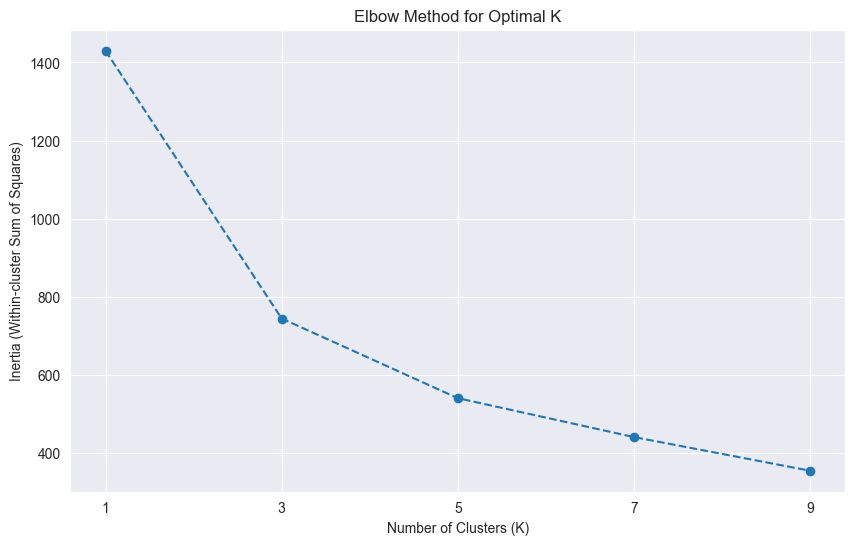

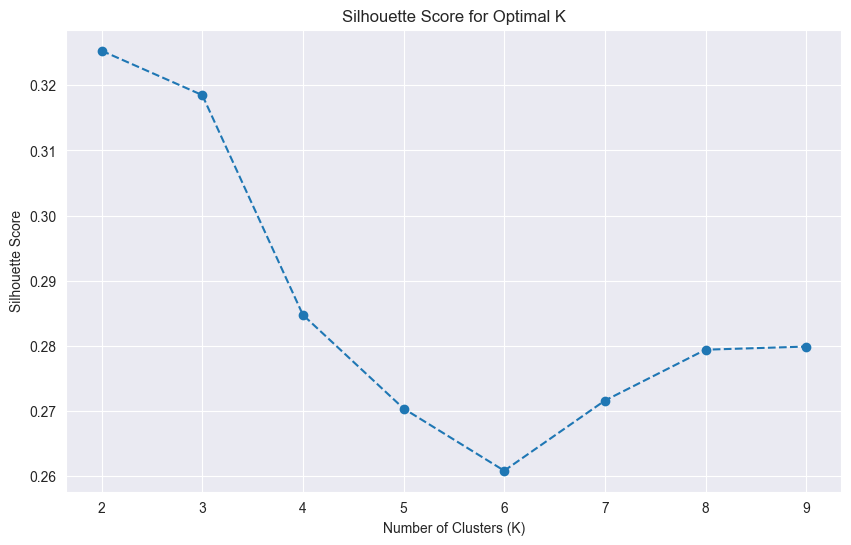

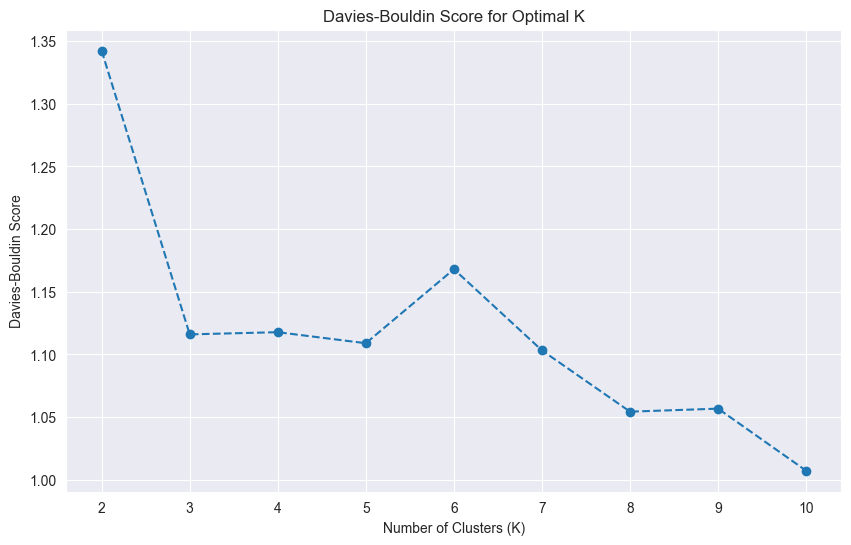

In [43]:
#finding the best K with Interia, Silhouette
inertia_values = []
max_k = 9
k_range = range(1, max_k + 1, 2)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') #runs the algorithm multiple times with different random initializations and picks the best one
    kmeans.fit(normalized_features)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

silhouette_scores = []
k_range_silhouette = range(2, max_k + 1)

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(normalized_features)
    score = silhouette_score(normalized_features, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()

db_scores = []
max_k = 10
k_range_db = range(2, max_k + 1)
for k in k_range_db:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(normalized_features)
    score = davies_bouldin_score(normalized_features, cluster_labels)
    db_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_range_db, db_scores, marker='o', linestyle='--')
plt.title('Davies-Bouldin Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(k_range_db)
plt.grid(True)
plt.show()

**The Elbow Method** - A method which helps us to choose the best number of centroids (k) in our model. The core idea behind the elbow method is that as you increase the number of clusters, the data points in each cluster will become closer to their respective cluster centroids. This will decrease the "inertia," or the sum of squared distances, for all the clusters At some point, adding another cluster will not significantly reduce the inertia. This is the "elbow" of the curve, where the rate of decrease in inertia slows down dramatically. This "elbow" point is considered to be the optimal number of clusters. The goal of the Elbow Method is to find the point where this decrease in inertia is no longer worth the added complexity of another cluster.

When using the Silhouette score, the optimal number of clusters (K) is identified by the highest score, as this indicates well-separated and compact clusters.

The Davies-Bouldin score graph shows a general trend of decreasing values as K increases. However, it can be observed that the value decreases most significantly at K=3. This value represents a balance between a low Davies-Bouldin score and the need to avoid overfitting with an excessive number of clusters.

Based on these findings, K=3 is the optimal number of clusters. This is supported by two key pieces of evidence: it corresponds to the highest Silhouette score, and it is the point in the Elbow method where the rate of decrease in inertia begins to diminish, forming a clear "elbow."

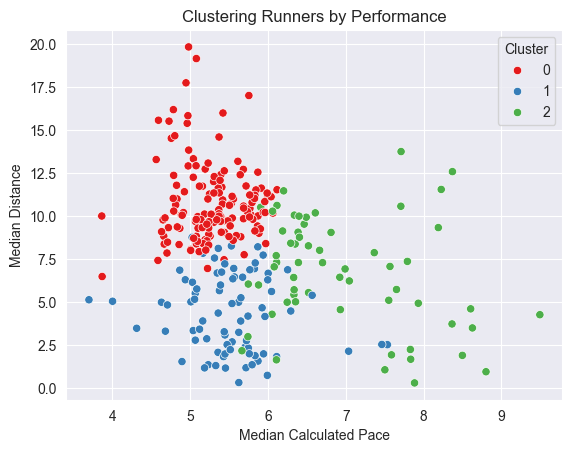

In [44]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_features)
final_df["Cluster"] =  cluster_labels
sns.scatterplot(x="Median Calculated Pace", y="Median Distance", hue="Cluster", data=final_df, palette="Set1")
plt.title("Clustering Runners by Performance")
plt.show()

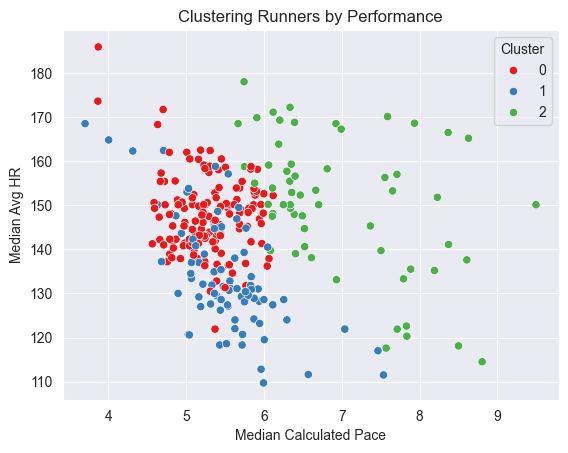

In [45]:
sns.scatterplot(x="Median Calculated Pace", y="Median Avg HR", hue="Cluster", data=final_df, palette="Set1")
plt.title("Clustering Runners by Performance")
plt.show()

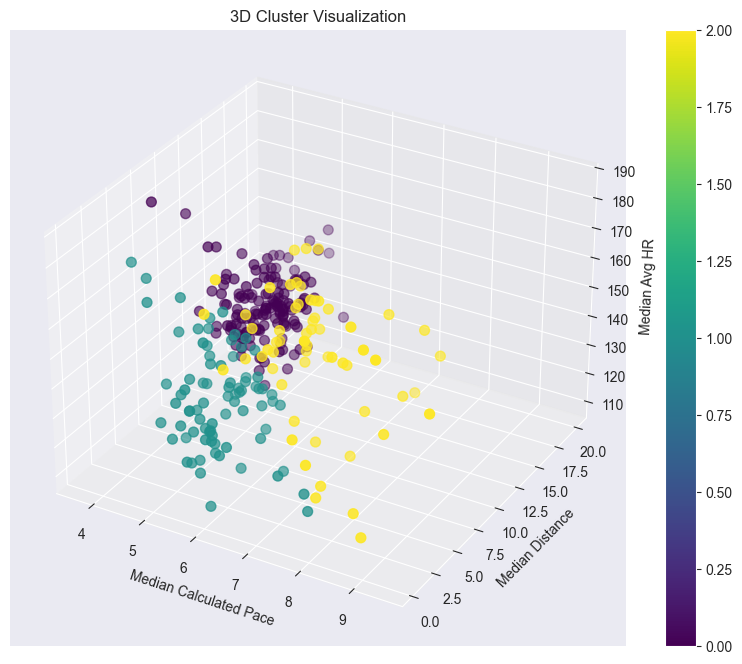

In [46]:
optimal_k = 3

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(final_df["Median Calculated Pace"], final_df['Median Distance'], final_df['Median Avg HR'], c=final_df['Cluster'], cmap='viridis', s=50)
plt.colorbar(sc)
ax.set_xlabel('Median Calculated Pace')
ax.set_ylabel('Median Distance')
ax.set_zlabel('Median Avg HR')
ax.set_title('3D Cluster Visualization')

plt.show()

#### Kmeans Conclusions
- We can see that the clustering provided clusters with the next characteristics:
    * <u>Cluster 0</u> - Low pace runners, distance is wide-spreaded (our 'Beginners')
    * <u>Cluster 1</u> - Medium to high pace ruuners, longer distances (our 'Advanced')
    * <u>Cluster 2</u> - Medium to high pace runners, short distances (our 'Intermediate')
- The analysis of the cluster's characteristics suggests that average heart rate was not a primary factor in the formation of the clusters.  A consistent range of average heart rates is observed across all clusters, indicating a uniform distribution of this feature. This finding is reinforced by the fact that the majority of runners have an average heart rate between 130 and 165 BPM.

**Example** - Based on the clustering we've processed I belong to cluster 1 which makes me a medium to high pace runner for long distances

In [47]:
print(final_df.loc[final_df["Runner"] == "maor"])

    Runner  Median Avg HR  Median Distance  Median Time  \
281   maor          162.0             8.02    40.766667   

     Median Calculated Pace  Median GRPS Score  Runner_Class  Cluster  
281                5.006653          23.651118  Intermediate        0  


**Using ARI and V-measure to compare the clusters to our initial GRPS classes**

In [48]:
class_mapping = {"Beginner": 0,"Intermediate": 2, "Advanced": 1}
final_df["Runner_Class_Numeric"] = final_df["Runner_Class"].map(class_mapping)
labels_true = final_df.loc[:, "Runner_Class_Numeric"]
labels_pred = final_df.loc[:, "Cluster"]
ari_score = adjusted_rand_score(labels_true, labels_pred)
print(f"Perfect match ARI score: {ari_score:.2f}")
v_score = v_measure_score(labels_true, labels_pred)
print(f"Perfect match V-measure score: {v_score:.2f}")

Perfect match ARI score: 0.25
Perfect match V-measure score: 0.33


We can see that the ARI is 0.2 and the V-measure is 0.28 which aren't great values. It may show that the Kmeans model found  patterns in our data which are different from the way we have decided to label our runner. It also can happen because the features used for clustering may not be the most significant ones for distinguishing between the runner classes as we defined them.

### Final conclusions

In this project I explored the problem of classifying runners into performance tiers using personal running data, common runing metrics (pace, distance, heart rate etc.) and a derived General Running Performance Score (GRPS) which is primarly based on Reigel formula.

I tested unsupervised clustering model (KMeans) and supervised models (Decision tree ,Logistic Regression, Random Forest, Gradient Boosting) and evaluated models using stratified cross-validation and a held-out test set.

The best performing classification models balanced precision and recall across the three classes, however, adjacent classes (Beginner vs Intermediate and Intermediate vs Advanced) remain the primary source of error, reflecting realistic overlap in runner abilities.

Feature-importance analysis showed that normalized pace was the most predictive feature to classify our runners based on the method we used to determine the labels (based on their GRPS score).

We also learned that our clustering model found diferrent patterns in the data than the labels we've had determined.

Overall, the project demonstrates a full end-to-end pipeline - data collection, feature engineering (GRPS metric), exploratory analysis, modeling based on multiple classification approaches and clustering , evaluation and has a touch to my daily areas of intrest. With a larger dataset and final polish on conclusions, it can stand out as a solid applied Data Science project.